<a href="https://colab.research.google.com/github/rafalsza/moje/blob/master/polynomial_linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install python-binance
!pip install pandas-ta

In [2]:
from binance.client import Client
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import time
from datetime import datetime
import pandas_ta as pta
import pandas.testing as tm
import os, sys
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [12]:
client = Client()
interval = '1d'
symbol = "BTCUSDT"
start_str = '501 days ago UTC'
end_str = f'{datetime.now()}'
# print(f"Fetching new bars for {datetime.now().isoformat()}")
df = pd.DataFrame(client.get_historical_klines(symbol, interval, start_str, end_str)[:-1]).astype(float)
df = df.iloc[:, :6]
df.columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume']
df = df.set_index('timestamp')
df.index = pd.to_datetime(df.index, unit='ms')
n1 = 10
n2 = 21
ap = pta.hlc3(df.high, df.low, df.close, talib=True)
esa = pta.ema(ap, n1, talib=True)
d = pta.ema(abs(ap - esa), n1, talib=True)
ci = (ap - esa) / (0.015 * d)
tci = pta.ema(ci, n2, talib=True)
wt1 = tci
cmo = pta.cmo(df.close,14, talib=True)

y = df['close'].tolist()
y = y[-500:]  # last 500 values from a list
print(f'last close: {y[-1]}')

x = range(len(y))
X = np.arange(0, 500)
X = X.reshape(500, 1)

sns.set()
lin_reg=LinearRegression()
lin_reg.fit(X,y)



last close: 36445.31


LinearRegression()

In [ ]:
from sklearn.metrics import r2_score
mymodel = np.poly1d(np.polyfit(x, y, 5))


plt.figure(figsize=(12,8))
plt.scatter(x, y,color='red')
plt.plot(x, mymodel(x))
plt.ylabel('Price')

print(r2_score(y, mymodel(x)))

speed = mymodel([-1])
print(speed)

In [13]:
fig = go.Figure()
ind = df.index[-500:].tolist()

x2 = list(np.arange(0,500))
lin1 = np.poly1d(np.polyfit(x2, y, 1))
lin2 = (np.poly1d(np.polyfit(x2, y - np.std(y), 1)))
lin3 = (np.poly1d(np.polyfit(x2, y + np.std(y), 1)))
poly3 = np.poly1d(np.polyfit(x2, y, 3))
poly4 = np.poly1d(np.polyfit(x2, y, 4))
poly5 = np.poly1d(np.polyfit(x2, y, 5))
poly7 = np.poly1d(np.polyfit(x2, y, 7))

fig = make_subplots(rows=2, cols=1,row_width=[0.2, 0.8],subplot_titles=[(f'Regression model {symbol} {interval}'),'cmo'])
fig.add_trace(go.Scatter(x=ind, y=y, name="price"))
fig.add_trace(go.Scatter(x=ind, y=poly3(x2), name="polynomial3",
                    line_shape='linear'))
fig.add_trace(go.Scatter(x=ind, y=poly4(x2), name="polynomial4",
                    line_shape='linear'))
fig.add_trace(go.Scatter(x=ind, y=poly5(x2), name="polynomial5",
                    line_shape='linear'))
fig.add_trace(go.Scatter(x=ind, y=poly7(x2), name="polynomial7",
                    line_shape='linear'))
fig.add_trace(go.Scatter(x=ind, y=lin1(x2), name="linear",
                    line_shape='linear',line = dict(color=('red' if lin1(x2)[0]>lin1(x2)[-1] else 'green'),width=2, dash='dash')))
fig.add_trace(go.Scatter(x=ind, y=lin2(x2), name="linear-std",
                    line_shape='linear',line = dict(color=('red' if lin1(x2)[0]>lin1(x2)[-1] else 'green'),width=2, dash='dash')))
fig.add_trace(go.Scatter(x=ind, y=lin3(x2), name="linear+std",
                    line_shape='linear',line = dict(color=('red' if lin1(x2)[0]>lin1(x2)[-1] else 'green'),width=2, dash='dash')))


fig.add_trace(go.Scatter(x=df.index[-500:],y=cmo[-500:], mode="lines",fill='tozeroy',fillcolor='blue',), row=2, col=1)

fig.update_layout(width=1000,height=600,legend=dict(x=1,y=0.5, traceorder='reversed', font_size=16))
fig.show()

print(f'linear rscore: {r2_score(y, lin1(x2))}')
print(f'linear * 1.01 rscore: {r2_score(y, lin2(x2))}')
print(f'linear * 0.99 rscore: {r2_score(y, lin3(x2))}')
print(f'poly7 rscore: {r2_score(y, poly7(x2))}')
print(f'poly5 rscore: {r2_score(y, poly5(x2))}')
print(f'poly4 rscore: {r2_score(y, poly4(x2))}')
print(f'poly3 rscore: {r2_score(y, poly3(x2))}')

linear rscore: 0.5016180012594272
linear * 1.01 rscore: -0.49838199874057354
linear * 0.99 rscore: -0.49838199874056843
poly7 rscore: 0.927926148032409
poly5 rscore: 0.8650202320843781
poly4 rscore: 0.6842974282420891
poly3 rscore: 0.6827355070019437


In [ ]:
plt.figure(figsize=(12,8))
plt.scatter(X,y,color='red')
plt.plot(X,lin_reg.predict(X),color='blue')
plt.title('Truth or bluff(Linear Regression)')
plt.xlabel('Position Level')
plt.ylabel('Price')
plt.show()


In [ ]:
y_pred1 = lin_reg.predict(X)
y_pred1[-1]

39875.89768455089

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly_reg=PolynomialFeatures(degree=4)
X_poly=poly_reg.fit_transform(X)
poly_reg.fit(X_poly,y)
lin_reg2=LinearRegression()
lin_reg2.fit(X_poly,y)

X_grid=np.arange(min(X),max(X),0.1)
X_grid=X_grid.reshape((len(X_grid),1))
plt.figure(figsize=(12,8))
plt.scatter(X,y,color='red')
plt.plot(X,lin_reg2.predict(poly_reg.fit_transform(X)),color='blue')
plt.title('Truth or bluff(Polynomial Regression)')
plt.xlabel('Position Level')
plt.ylabel('Price')
plt.show()

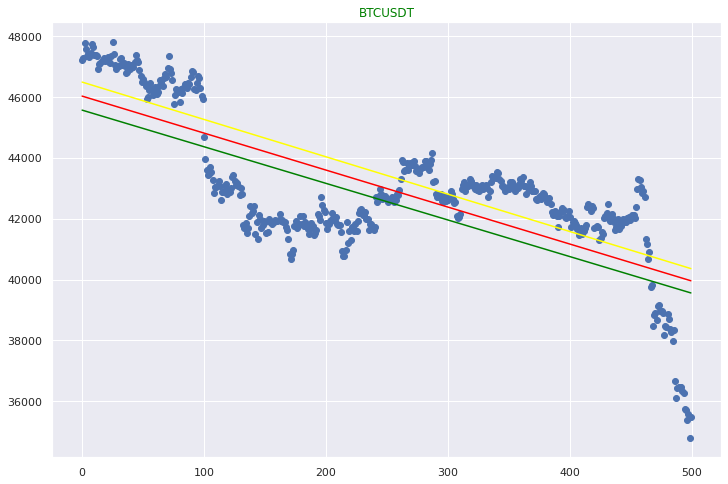

In [10]:
regressor = LinearRegression()
regressor.fit(X, y)
y_pred01 = regressor.predict(X)
y_pred02 = (regressor.predict(X)) * 1.01
y_pred03 = (regressor.predict(X)) * 0.99

plt.figure(figsize=(12,8))
plt.title(label=f'{symbol}', color="green")
plt.grid(True)
plt.scatter(X, y)
_ = plt.plot(X, y_pred01, c='red')
_ = plt.plot(X, y_pred02, c='yellow')
_ = plt.plot(X, y_pred03, c='green')

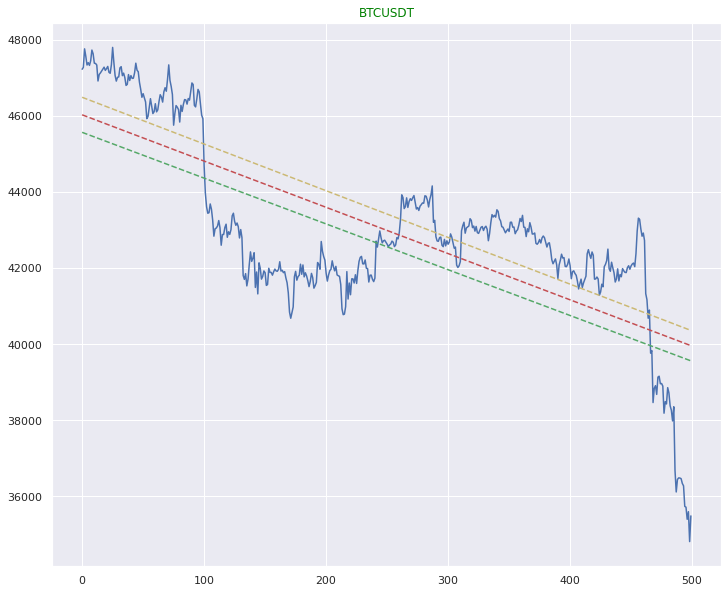

In [11]:
plt.figure(figsize=(12, 10))
plt.grid(True)
plt.plot(y)
plt.title(label=f'{symbol}', color="green")
plt.plot(y_pred01, '--', color='r')
plt.plot(y_pred02, '--', color='y')
plt.plot(y_pred03, '--', color='g')

In [ ]:
y_pred01[-1]

40881.36033437126

In [ ]:
y_pred02[-1]

41424.254548031146

In [ ]:
from sklearn.metrics import r2_score

print(r2_score(y, y_pred01))
print(r2_score(y, y_pred02))
print(r2_score(y, y_pred03))

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=6)
X_poly = poly.fit_transform(X)
X_poly

In [ ]:
regressor_poly = LinearRegression()
regressor_poly.fit(X_poly, y)

y_pred_p1 = regressor_poly.predict(X_poly)

plt.figure(figsize=(12, 10))
plt.grid(True)
plt.plot(y)
plt.title(label=f'{symbol}', color="green")
plt.plot(y_pred_p1, '--', color='r')

In [ ]:
print(r2_score(y, y_pred_p1))

0.9383105065051097
